<a href="https://colab.research.google.com/github/hgene0929/deep_learning/blob/main/img_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. 입력 이미지로 사용될 이미지 업로드 및 저장소 생성

In [1]:
!mkdir /content/data

2. 업로드 한 이미지 로딩
- cv2.imread() : 이미지 읽어오기
- cv2.cvtColor() : BGR로 변환된 이미지를 RGB로 다시 변환

3. Tensorflow에서 Pretrained 된 Inference모델(Frozen graph)와 환경파일을 다운로드 받은 후 이를 이용해 OpenCV에서 Inference 모델 생성
- https://github.com/opencv/opencv/wiki/TensorFlow-Object-Detection-API 에 다운로드 URL 있음.
- pretrained 모델은 http://download.tensorflow.org/models/object_detection/mask_rcnn_inception_v2_coco_2018_01_28.tar.gz 에서 다운로드 후 압축 해제
- pretrained 모델을 위한 환경 파일은 https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/mask_rcnn_inception_v2_coco_2018_01_28.pbtxt 에서 다운로드
- download된 모델 파일과 config 파일을 인자로 하여 inference 모델을 DNN에서 로딩함.

In [ ]:
!mkdir ./pretrained
!wget -O ./pretrained/mask_rcnn_inception_v2_coco_2018_01_28.tar.gz http://download.tensorflow.org/models/object_detection/mask_rcnn_inception_v2_coco_2018_01_28.tar.gz
!wget -O ./pretrained/config_mask_graph.pbtxt https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/mask_rcnn_inception_v2_coco_2018_01_28.pbtxt

!tar -xvf ./pretrained/mask*.tar.gz -C ./pretrained 

4. coco 데이터 세트의 클래스id별 클래스명 지정.

In [19]:
# coco dataset의 클래스 ID별 클래스명 매핑
labels_to_names_seq= {0:'person',1:'bicycle',2:'car',3:'motorcycle',4:'airplane',5:'bus',6:'train',7:'truck',8:'boat',9:'traffic light',
                    10:'fire hydrant',11:'street sign',12:'stop sign',13:'parking meter',14:'bench',15:'bird',16:'cat',17:'dog',18:'horse',19:'sheep',
                    20:'cow',21:'elephant',22:'bear',23:'zebra',24:'giraffe',25:'hat',26:'backpack',27:'umbrella',28:'shoe',29:'eye glasses',
                    30:'handbag',31:'tie',32:'suitcase',33:'frisbee',34:'skis',35:'snowboard',36:'sports ball',37:'kite',38:'baseball bat',39:'baseball glove',
                    40:'skateboard',41:'surfboard',42:'tennis racket',43:'bottle',44:'plate',45:'wine glass',46:'cup',47:'fork',48:'knife',49:'spoon',
                    50:'bowl',51:'banana',52:'apple',53:'sandwich',54:'orange',55:'broccoli',56:'carrot',57:'hot dog',58:'pizza',59:'donut',
                    60:'cake',61:'chair',62:'couch',63:'potted plant',64:'bed',65:'mirror',66:'dining table',67:'window',68:'desk',69:'toilet',
                    70:'door',71:'tv',72:'laptop',73:'mouse',74:'remote',75:'keyboard',76:'cell phone',77:'microwave',78:'oven',79:'toaster',
                    80:'sink',81:'refrigerator',82:'blender',83:'book',84:'clock',85:'vase',86:'scissors',87:'teddy bear',88:'hair drier',89:'toothbrush',
                    90:'hair brush'}

5. Detect된 Object에 대해서 bounding box와 mask를 시각화 함수 생성.

In [31]:
import numpy as np

def get_box_info(box, img_width, img_height):
    
    classId = int(box[1])
    left = int(img_width * box[3])
    top = int(img_height * box[4])
    right = int(img_width * box[5])
    bottom = int(img_height * box[6])
    
    left = max(0, min(left, img_width - 1))
    top = max(0, min(top, img_height - 1))
    right = max(0, min(right, img_width - 1))
    bottom = max(0, min(bottom, img_height - 1))
    
    return classId, left, top, right, bottom

    
def draw_box(img_array, box, img_width, img_height, is_print=False):
    green_color=(0, 255, 0)
    red_color=(0, 0, 255)
    
    score = box[2]
    classId, left, top, right, bottom = get_box_info(box, img_width, img_height)
    text = "{}: {:.4f}".format(labels_to_names_seq[classId], score)
    
    if is_print:
        print("box:", box, "score:", score, "classId:", classId)
    
    cv2.putText(img_array, "CLICK HERE!!!", (left, top-3), cv2.FONT_HERSHEY_SIMPLEX, 0.5, red_color, thickness=2)
    
    return img_array
    
def draw_mask(img_array, box, mask, img_width, img_height, mask_threshold, is_print=False):
        
        classId, left, top, right, bottom = get_box_info(box, img_width, img_height)
        classMask = mask[classId]
        # 원본 이미지의 object 크기에 맞춰 mask 크기 scale out 
        scaled_classMask = cv2.resize(classMask, (right - left + 1, bottom - top + 1))
        s_mask_b = (scaled_classMask > mask_threshold)
        before_mask_roi = img_array[top:bottom+1, left:right+1]
        
        # mask를 적용할 bounding box 영역의 image 추출하고 투명 color 적용. 
        colorIndex = np.random.randint(0, len(colors)-1)
        color = colors[colorIndex]
        # after_mask_roi = img_array[top:bottom+1, left:right+1][s_mask_b]
        # img_array[top:bottom+1, left:right+1][s_mask_b] = ([0.3*color[0], 0.3*color[1], 0.3*color[2]] + 0.6 * after_mask_roi).astype(np.uint8)
        # Detect된 Object에 윤곽선(contour) 적용. 
        s_mask_i = s_mask_b.astype(np.uint8)
        contours, hierarchy = cv2.findContours(s_mask_i,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(img_array[top:bottom+1, left:right+1], contours, -1, color, 1, cv2.LINE_8, hierarchy, 300)
        
        return img_array

In [21]:
import time

def detect_image_mask_rcnn(cv_net, img_array, conf_threshold, mask_threshold, use_copied_array, is_print=False):
    
    draw_img = None
    if use_copied_array:
        draw_img = img_array.copy()
        #draw_img = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)
    else:
        draw_img = img_array
        
    start_time = time.time()
    
    blob = cv2.dnn.blobFromImage(img_array, swapRB=True, crop=False)
    cv_net.setInput(blob)
    boxes, masks = cv_net.forward(['detection_out_final', 'detection_masks'])
    
    inference_time = time.time() - start_time
    if is_print:
        print('Segmentation Inference time {0:}'.format(inference_time))

    numClasses = masks.shape[1]
    numDetections = boxes.shape[2]

    img_height = img_array.shape[0]
    img_width = img_array.shape[1]
    
    for i in range(numDetections):
        box = boxes[0, 0, i]
        mask = masks[i]
        score = box[2]
        #print("score:", score)
        if score > conf_threshold:
            draw_box(img_array , box, img_width, img_height, is_print=is_print)
            draw_mask(img_array, box, mask, img_width, img_height, mask_threshold, is_print=is_print)
    
    return img_array

6. 업로드 한 이미지 로딩
- cv2.imread() : 이미지 읽어오기
- cv2.cvtColor() : BGR로 변환된 이미지를 RGB로 다시 변환

7. dnn에서 readNetFromTensorflow()로 tensorflow inference 모델을 로딩 후 Inference 수행 cv_net.forward() 수행 시 Bounding box Inference(bbox regression, bbox classification)과 mask inference 결과를 함께 출력하기 위해 layer명 detection_out_final, detection_masks 결과 가져옴

Segmentation Inference time 4.598055124282837
box: [0.         2.         0.9787119  0.73163444 0.45841032 1.
 0.5282344 ] score: 0.9787119 classId: 2
box: [0.         2.         0.92539823 0.24343207 0.45943895 0.33703485
 0.4914913 ] score: 0.92539823 classId: 2
box: [0.         7.         0.5854609  0.33542103 0.44281772 0.59248626
 0.53803504] score: 0.5854609 classId: 7
box: [0.         2.         0.5617121  0.334561   0.44206184 0.5868223
 0.5370399 ] score: 0.5617121 classId: 2


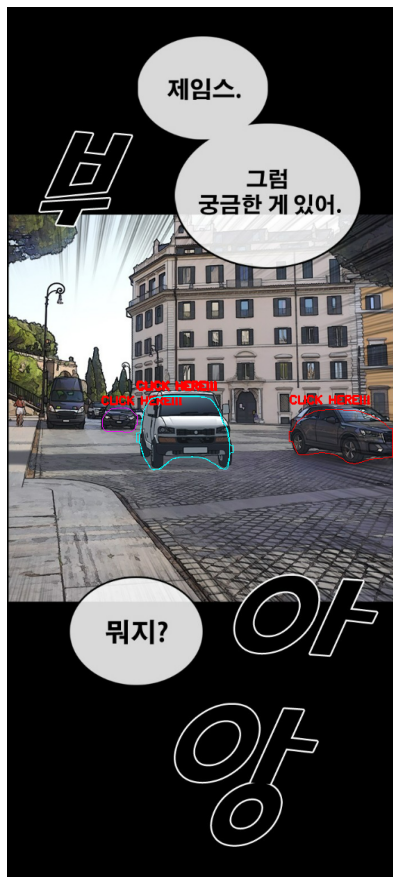

In [32]:
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

cartoon_img = cv2.imread('./data/cartoon_img.png')

cv_net = cv2.dnn.readNetFromTensorflow('./pretrained/mask_rcnn_inception_v2_coco_2018_01_28/frozen_inference_graph.pb', './pretrained/config_mask_graph.pbtxt')

img_detected = detect_image_mask_rcnn(cv_net, cartoon_img, conf_threshold=0.5, mask_threshold=0.5, use_copied_array=True, is_print=True)

img_rgb = cv2.cvtColor(img_detected, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(16, 16))
plt.axis('off')
plt.imshow(img_rgb)